# Computer Vision and Convolutional Neural Networks (CNNs)

Computer Vision was the first area where the power of deep learning was demonstrated. In this notebook we will work through the implementation of an architecture for a classification of hand-written digits and letters using the EMNIST dataset. The figure below shows the classes present in the data.

https://docs.google.com/presentation/d/17Uygrr1g6qBMpXOwcfZf584PkW2LTZoXgX1mqsK6syE/edit?usp=sharing

We will use the EMNIST dataset which contains . You will experiment with different CNN architecture choices to understand their importance for accurate image recognition. 

In addition to the digits 0-9, EMNIST has 37 upper and lower-case latin characters (see Figure) for a total of 47 classes. The added classes make EMNIST a more difficult classification task than the original MNIST.

![Balanced EMNIST Dataset](https://www.researchgate.net/publication/329391937/figure/fig3/AS:700515201605633@1544027247072/Visualization-of-EMNIST-balanced-dataset-10-Fig2.ppm)

To complete the assignment, work through the notebook, following the prompts and answer the questions. Submit your answers using [this google form](https://forms.gle/2n6uH5B8RmH6Ndx1A). You will need to save a copy of the notebook to your own Google Drive using the File menu above. 

You will need to use a GPU-enabled runtime to complete this assignment. Please go ahead and make sure you have a GPU runtime by selecting `Runtime > Change runtime type` from the menu above. If not already selected, choose `GPU` from the `Hardware accelerator` dropdown menu. 

### References: 
* [EMNIST homepage](https://www.westernsydney.edu.au/icns/reproducible_research/publication_support_materials/emnist)
* [EMNIST paper on arxiv](https://arxiv.org/pdf/1702.05373.pdf)
* [Original CNN Notebook](https://colab.research.google.com/drive/1VXIwT42W1b6yx2xdVsXfazk4_vvMNdY8?usp=sharing)
* Slides on CNNs from Watt AI Course: 
    * [Part 1](https://docs.google.com/presentation/d/19W9-BYMxKnYhPlVkcD4yjao3wO08NI4Dcmbt67EYbGY/edit?usp=sharing)
    * [Part 2](https://docs.google.com/presentation/d/1am6YVLQn-kN7R4qNPGsmt2C0swxXqlFnjSgWpqvNOqQ/edit?usp=sharing)

# Setup

In [1]:
# @title Import libraries

# Library imports
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from PIL import Image
import math
%matplotlib inline

# set random seed for reproducibility
_ = torch.manual_seed(0)

In [2]:
#@title Model and Training Settings
batch_size=64 #input batch size for training (default: 64)
test_batch_size=1000 #input batch size for testing (default: 1000)
lr=1.0 #learning rate (default: 1.0)
gamma=0.7 #Learning rate step gamma (default: 0.7)
no_cuda=False #disables CUDA training (default: True)
seed=42 #random seed (default: 42)
log_interval=150 #how many batches to wait before logging training status (default: 10)
save_model=False #save the trained model (default: False)

# additional derived settings
use_cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

print("Device:", device)

Device: cuda


In [3]:
# @title Loading the data
# define pytorch dataloaders for training and testing
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='balanced', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='balanced', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=test_batch_size, shuffle=False, **kwargs)

image_gen = iter(test_loader)
test_img, test_trg = next(image_gen)

100%|██████████| 561753746/561753746 [00:17<00:00, 32250396.12it/s]


Extracting ../data/EMNIST/raw/gzip.zip to ../data/EMNIST/raw


In [4]:
print("Training dataset:", train_loader.dataset)
print("Testing dataset:", test_loader.dataset)

Training dataset: Dataset EMNIST
    Number of datapoints: 112800
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Testing dataset: Dataset EMNIST
    Number of datapoints: 18800
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


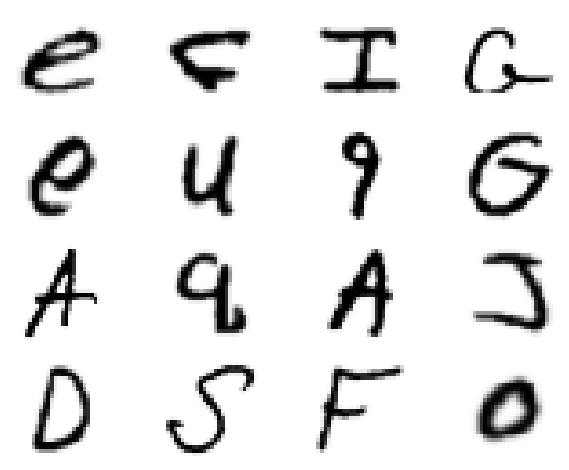

In [5]:
#@title Look at the data:
n_images = 16
rand_imgs = next(iter(test_loader))
ints = torch.randint(0,len(rand_imgs[0]), (n_images,))

fig, ax_arr = plt.subplots(4, 4)
ax_arr = ax_arr.flatten()

for n, ix in enumerate(ints):
  img = rand_imgs[0][ix]
  ax_arr[n].imshow(img[0].detach().cpu().numpy().T, cmap='Greys')
  ax_arr[n].axis('off')
plt.tight_layout()
plt.show()



---

**Question 1**: In addition to the larger number of classes in EMNIST compared to MNIST, why might it be more difficult to accurately classify images from the EMNIST set?

---


In [6]:
#@title Training and testing functions
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('\r\tTrain epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='')
            
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\rTest epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
def train_and_test(model, save_name='model.pt', epochs=5):
    # @title Train the linear model
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader, epoch)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), save_name)

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

# Classification architectures
We will explore a range of classification architectures starting with a linear classifier and scaling up to a several-layer convolutional neural network. Each architecture can be described in two steps (see figure below):
1. Feature extraction -- converting the raw pixel information into a _feature vector_
2. Classification -- converting the feature vector into predictions about the character in the input image.

![CNN diagram](https://miro.medium.com/max/1400/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg)

Most of the secret sauce of CNNs takes place in the feature extraction step. We will define a generic classification architecture that takes as input the sequence of operations used for feature extraction. We will use progressively more complex feature extraction pipelines. For the classification step, we will always use a single linear layer, but the number of inputs will depend on the size of the feature vector produced by the feature extractor. 

The class defined below implements this generic classifier class in pytorch. 

In [7]:
# Define the generic EMNIST classification architecture
# The `feature_extractor` argument takes images as input and produces feature vectors.
# These vectors can be of any length. 
class Classifier(nn.Module):
    def __init__(self, feature_extractor):
        super(Classifier, self).__init__()

        # feature encoder
        self.feature_extractor = feature_extractor
        
        # classifier
        self.classifier = nn.LazyLinear(47)

    def forward(self, x):
        x = self.feature_extractor(x) # Flatten -> x_i
        x = self.classifier(x) # Matrix multiply -> c_m^0 + sum(W_mi*x_i)
        x = F.softmax(x, dim=1) # apply the softmax function
        return x

# Linear Classifier

A linear classifier uses the original pixels as the features for classification. We simply need to unravel the 2D image into a vector. This is accomplished using `nn.Flatten()`. 

Note: you can safely ignore the message `UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development`

In [8]:
# set random seed for reproducibility
torch.manual_seed(0)

# define the feature extractor
# for linear model, we just flatten the original image into a vector
feature_extractor = nn.Flatten()

# Create the model
model = Classifier(feature_extractor).to(device)

/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/envs/pytorch_workshop/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
# @title Display model and number of parameters 
# Run one batch through the model to initialize the lazy linear layer
# this is necessary to get accurate parameter counts
with torch.no_grad():
    model(test_img.to(device)) 

display(model)

print("Number of parameters in linear model:", get_n_params(model))

Classifier(
  (feature_extractor): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=784, out_features=47, bias=True)
)

Number of parameters in linear model: 36895


---

**Question 2**: You should find that the linear model has 36,895 parameters compared with 7,850 when using the linear model with MNIST. Both EMNIST and MNIST contain 28x28 pixel images, so why does the linear model for EMNIST have so many more parameters?

---

## Train and test the linear model

In [10]:
train_and_test(model)

# by default, `train_and_test` trains for 5 epochs
# you can adjust this using the epochs argument, like
# train_and_test(model, epochs=2)

Test epoch 1: Average loss: 3.3020, Accuracy: 11264/18800 (59.91%)
Test epoch 2: Average loss: 3.2766, Accuracy: 11716/18800 (62.32%)
Test epoch 3: Average loss: 3.2662, Accuracy: 11899/18800 (63.29%)
Test epoch 4: Average loss: 3.2604, Accuracy: 11989/18800 (63.77%)
Test epoch 5: Average loss: 3.2485, Accuracy: 12224/18800 (65.02%)


---

**Question 3**: How accurate is the linear model after 5 epochs? How does this compare with the MNIST digit classification result used in the lecture? Why do you think it worked out that way? 

---

# CNN Classifier

### One convolution layer
We now make a more interesting feature extractor using convolution. The feature extractor has the following steps: 
1. _convolution_ (`nn.Conv2d`) over the input image.
2. _batch normalization_ (`nn.BatchNorm2d`) rescales the feature maps. This helps the network converge more quickly. You can see the definition [here](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html).
3. _ReLU_ (`nn.ReLU`) zeroes out negative values in the feature maps. 
4. _max pooling_ (`nn.MaxPool2d`) takes the maximum pixel from each 2x2 block resulting in an image that has half the size in each dimension. 

In [11]:
# set random seed for reproducibility
torch.manual_seed(0)

# define the feature extractor
feature_extractor = nn.Sequential(
    # convolution block:
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2),
    # flatten just as with the linear classifier
    nn.Flatten()
)
# Create the model
model = Classifier(feature_extractor).to(device)

In [12]:
# @title Display model and number of parameters 
# Run one batch through the model to initialize the lazy linear layer
# this is necessary to get accurate parameter counts
with torch.no_grad():
    model(test_img.to(device)) 

display(model)

print("Number of parameters in linear model:", get_n_params(model))

Classifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=676, out_features=47, bias=True)
)

Number of parameters in linear model: 31863


(Less than 36,895 for linear model)

In [13]:
train_and_test(model)

Test epoch 1: Average loss: 3.2283, Accuracy: 12484/18800 (66.40%)
Test epoch 2: Average loss: 3.1817, Accuracy: 13378/18800 (71.16%)
Test epoch 3: Average loss: 3.1581, Accuracy: 13784/18800 (73.32%)
Test epoch 4: Average loss: 3.1469, Accuracy: 14009/18800 (74.52%)
Test epoch 5: Average loss: 3.1428, Accuracy: 14097/18800 (74.98%)


---

**Question 4**: Why does the CNN beat the linear model after 5 epochs despite having fewer parameters?

---

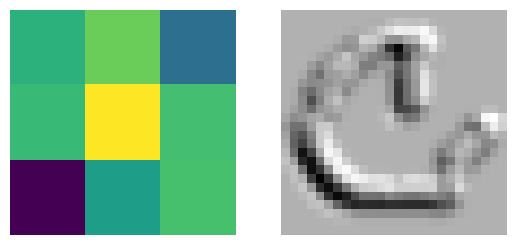

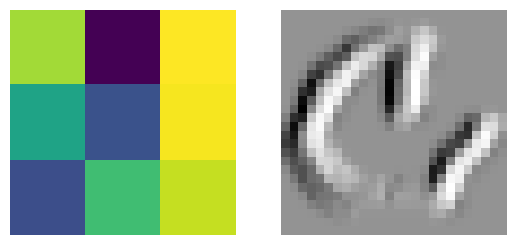

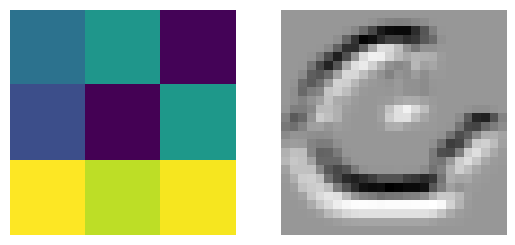

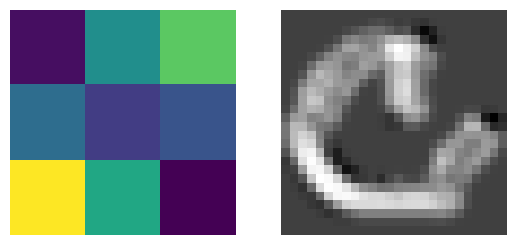

In [14]:


3

imgs, labels = next(image_gen)
test_img_plot = imgs[6,0]

kern = model.feature_extractor[0]

#@title Generate feature maps
fmaps_1 = kern(test_img_plot[None, None].cuda()).detach().cpu().numpy()[0]
for K, fmap in zip(kern.weight, fmaps_1):
  # plot kernel
  plt.subplot(1,2,1)
  mat = K.clone().detach().cpu().numpy()[0]
  plt.imshow(mat.T)
  plt.axis('off')

  # plot feature map
  plt.subplot(1,2,2)
  plt.imshow(fmap.T, cmap='Greys')
  plt.axis('off')
  plt.show()

In the cell above, the colored grids on the left are representations of the convolution kernel matrices. The values of these kernel matrices were "learned" during the training of the network. The image on the right is the feature map produced by convolving the kernel matrix with the original image. Bright areas correspond to high numerical values; dark areas correspond to low numerical values. 

---

**Question 5**: 
1. Upload a screen capture of your feature maps (the left column of images) to the Google form
2. Rerun the above cell several times to see the activation maps for several characters. Describe which features in the original image each of the 4 kernels appear to be highlighting. Why might these features be useful for correctly classifying hand-written characters?

---

# A "wider" model
The "width" of a CNN refers to how many feature maps are used in the convolution layers. Wide layers have many convolution kernels leading to many feature maps. In the model above, we had 4 convolution kernels (see `out_channels=4` in the `nn.Conv2d` layer in the feature extractor). Interpreting these kernels as feature extractors, it's plausible that we could improve the performance of the model by increasing the number of kernels.

The network below is the same as the previous one except that it uses twice as many kernels. 

In [15]:
# set random seed for reproducibility
torch.manual_seed(0)

# define the feature extractor
feature_extractor = nn.Sequential(
    # convolution block:
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2),
    # flatten just as with the linear classifier
    nn.Flatten()
)

# Create the model
model = Classifier(feature_extractor).to(device)

In [16]:
# @title Display model and number of parameters 
# Run one batch through the model to initialize the lazy linear layer
# this is necessary to get accurate parameter counts
with torch.no_grad():
    model(test_img.to(device)) 

display(model)

print("Number of parameters in linear model:", get_n_params(model))

Classifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=1352, out_features=47, bias=True)
)

Number of parameters in linear model: 63679


Notice that doubling the number of channels nearly doubled the number of free parameters in the model. 

In [17]:
train_and_test(model)

Test epoch 1: Average loss: 3.2283, Accuracy: 12468/18800 (66.32%)
Test epoch 2: Average loss: 3.1334, Accuracy: 14267/18800 (75.89%)
Test epoch 3: Average loss: 3.1114, Accuracy: 14663/18800 (77.99%)
Test epoch 4: Average loss: 3.1033, Accuracy: 14829/18800 (78.88%)
Test epoch 5: Average loss: 3.0973, Accuracy: 14918/18800 (79.35%)


---

**Question 6**: How does the performance with 8 kernels compare to the performance with 4 kernels? Why do you think this might be the case?

---

# A "deeper" model


The "depth" of a CNN refers to how many convolution layers are used in the network. The feature maps from one convolution step are used as the input for the next convolution. The previous network had a single convolution step. We will now try adding more convolution layers and see how it effects performance. To isolate the effect of having more layers, we will hold the width at 4 kernels like our first CNN.

---

**Question 7**: Why might it be helpful to add more convolutional layers to the CNN?

---

In [18]:
# set random seed for reproducibility
torch.manual_seed(0)

# define the encoder
# we repeat the convolution block several times
feature_extractor = nn.Sequential(
    # block 1
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    # 2
    nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    # 3
    nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2),
    # flatten just as with the linear classifier
    nn.Flatten()
)

# Create the model
model = Classifier(feature_extractor).to(device)

In [19]:
# @title Display model and number of parameters 
# Run one batch through the model to initialize the lazy linear layer
# this is necessary to get accurate parameter counts
with torch.no_grad():
    model(test_img.to(device)) 

display(model)

print("Number of parameters in linear model:", get_n_params(model))

Classifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=484, out_features=47, bias=True)
)

Number of parameters in linear model: 23143


The number of parameters is actually _less_ than our single layer model. We added lots of convolution kernels, so how can that be? Most of the parameters come from the final linear layer. Each convolution layer trims off a row of pixels around the image. This, in turn reduces the size of the final feature vector which reduces the number of parameters in the final linear layer. This reduction is greater than the number of new parameters in the added convolution layers.

In [20]:
train_and_test(model)

Test epoch 1: Average loss: 3.2106, Accuracy: 12774/18800 (67.95%)
Test epoch 2: Average loss: 3.1319, Accuracy: 14263/18800 (75.87%)
Test epoch 3: Average loss: 3.1148, Accuracy: 14557/18800 (77.43%)
Test epoch 4: Average loss: 3.1063, Accuracy: 14742/18800 (78.41%)
Test epoch 5: Average loss: 3.1039, Accuracy: 14764/18800 (78.53%)


---

**Question 8**: You should find that the deeper model outperformed the wider model despite having many fewer parameters. Why do you think increasing the depth of the model was more effective than increasing the width?

---

# Your turn! 
Modify the feature extractor below and see how good of a score you can obtain on EMNIST. Some ideas: 
* Change the number of channels in the convolution layers. Note: the `in_channels` argument to `nn.Conv2d` must match the `out_channels` argument from a previous layer. The input image has 1 channel since the images are grayscale.
* Change the `kernel_size`, which is the size of the kernel matrix used in convolution. 
* Change the number of convolution blocks in the network.
* Try [different activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).
* Add or remove max pooling layers between convolution blocks
* Use a greater number of epochs in the `train_and_test` function

There are many, many possible combinations that you could try, and you can't explore them all. Try to think of a few experiments to try and record what you learn. If you want to go down the rabbit hole of trying many things, feel free, but that's not expected for this assignment.

Try to beat my score of 83.4% resulting from using the "deeper model" above trained for 13 epochs.

---

**Question 9:** 
1. Upload two screencaps: i) the printout for your best training run and ii) the code defining your feature extractor for this run.
2. What was your highest percent accuracy score? 
3. Summarize what you learned in your experimentation. What worked well? What didn't work well? What surprised you?

---

In [21]:
# set random seed for reproducibility
torch.manual_seed(0)

# define the encoder
# we repeat the convolution block several times
feature_extractor = nn.Sequential(
    # block 1
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    # block 2
    # the value of `in_channels` has to match `out_channels` from the previous step
    nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    # block 3
    nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2),
    # flatten just as with the linear classifier
    nn.Flatten()
)

# Create the model
model = Classifier(feature_extractor).to(device)

In [22]:
train_and_test(model, epochs=5)

Test epoch 1: Average loss: 3.2606, Accuracy: 11945/18800 (63.54%)
Test epoch 2: Average loss: 3.0921, Accuracy: 15013/18800 (79.86%)
Test epoch 3: Average loss: 3.0805, Accuracy: 15202/18800 (80.86%)
Test epoch 4: Average loss: 3.0712, Accuracy: 15376/18800 (81.79%)
Test epoch 5: Average loss: 3.0685, Accuracy: 15430/18800 (82.07%)
